<a href="https://colab.research.google.com/github/Tuna10001/Assignments-on-remote-sensing-and-water-quality-data-analysis/blob/main/Zonal_stat_from_netCDF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip3 install netcdf4 xarray --quiet
!pip3 install rioxarray --quiet
!pip3 install geopandas --quiet
!pip install regionmask --quiet
!pip3 install wget --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 4.3 MB/s eta 0:00:00


In [ ]:
import xarray as xr
import rioxarray as rio
import os
import geopandas as gpd
import matplotlib.pyplot as plt

In [ ]:
# get climate data - average temprature from GFLD_ESM4 climate model using wget
url = 'https://files.isimip.org/ISIMIP3b/InputData/climate/atmosphere/bias-adjusted/global/daily/historical/GFDL-ESM4/gfdl-esm4_r1i1p1f1_w5e5_historical_tas_global_daily_2001_2010.nc'

import wget

data_dir = f'/content/ISIMIP/temp'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)


filename = wget.download(url, out=data_dir)
ds = xr.open_dataset(filename)
ds

<xarray.Dataset> Size: 4GB
Dimensions:  (lon: 720, lat: 360, time: 3652)
Coordinates:
  * lon      (lon) float64 6kB -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
  * lat      (lat) float64 3kB 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75
  * time     (time) datetime64[ns] 29kB 2001-01-01 2001-01-02 ... 2010-12-31
Data variables:
    tas      (time, lat, lon) float32 4GB ...
Attributes:
    institution:  Potsdam Institute for Climate Impact Research (PIK)
    contact:      ISIMIP cross-sectoral science team <info@isimip.org> <https...
    references:   Lange (2019) <https://doi.org/10.5194/gmd-12-3055-2019> and...
    title:        ISIMIP3b bias-adjusted climate input data
    project:      Inter-Sectoral Impact Model Intercomparison Project phase 3...
    summary:      CMIP6 daily output data bias-adjusted and statistically dow...

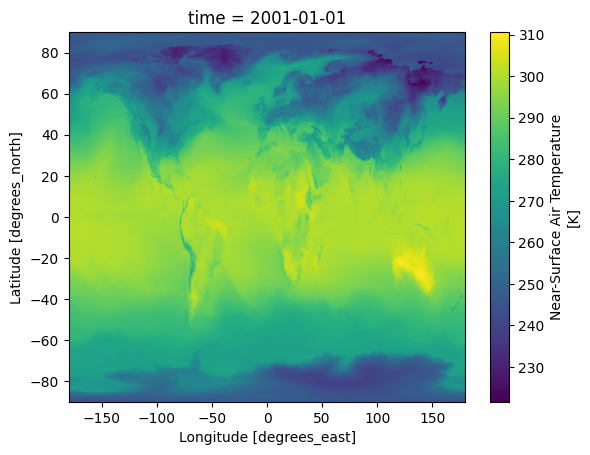

In [ ]:
ds.tas[0].plot()

In [ ]:
#Get shapefile of Kenya
%%capture
import shutil
import urllib.request
from contextlib import closing


shp_dir = f'/content/Kenya'
if not os.path.exists(shp_dir):
    os.makedirs(shp_dir)

Kenya_shp_file = r'https://data.humdata.org/dataset/2c0b7571-4bef-4347-9b81-b2174c13f9ef/resource/03df9cbb-0b4f-4f22-9eb7-3cbd0157fd3d/download/ken_adm_iebc_20191031_shp.zip'
kenya_shp = '/content/Kenya/KE.zip'
with closing(urllib.request.urlopen(Kenya_shp_file)) as r:
    with open(kenya_shp, 'wb') as f:
        shutil.copyfileobj(r, f)

# unzip the downloaded shapefile of the world countries
!unzip '/content/Kenya/KE.zip' -d Kenya

<Axes: >

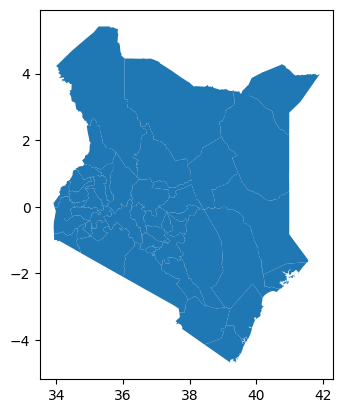

In [ ]:
KE = gpd.read_file(r"/content/Kenya/ken_admbnda_adm1_iebc_20191031.shp")
KE = KE.reset_index()
KE.plot()

In [ ]:
# clip the netCDF file wuusing Kenya shapefile
ds = ds.rio.write_crs("EPSG:4326")
KE.crs = "EPSG:4326"
ds_ke = ds.rio.clip(KE.geometry.values,KE.crs, all_touched =True, drop=True, )

<Axes: title={'center': 'time = 2001-01-01, spatial_ref = 0'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>

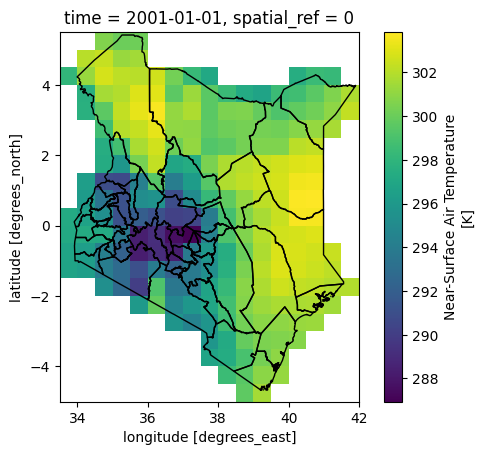

In [ ]:
# plot the clipped dataset and the kenya shapefile
fig, ax = plt.subplots()
ds_ke.tas[0].plot.pcolormesh( ax=ax)
KE.plot(ax=ax, edgecolor='k', color='none')

In [ ]:
# zonal stat with regionmask

import regionmask

# Create mask of multiple regions from shapefile
kenya_mask = regionmask.mask_3D_geopandas(
        KE,
        ds_ke.lon,
        ds_ke.lat,
        drop=True,
        numbers="index"
    )

# Apply mask on the dataset
ds_region = ds_ke.where(kenya_mask)
ds_region

<xarray.Dataset> Size: 198MB
Dimensions:      (time: 3652, lat: 21, lon: 17, region: 38)
Coordinates:
  * lon          (lon) float64 136B 33.75 34.25 34.75 ... 40.75 41.25 41.75
  * lat          (lat) float64 168B 5.25 4.75 4.25 3.75 ... -3.75 -4.25 -4.75
  * time         (time) datetime64[ns] 29kB 2001-01-01 2001-01-02 ... 2010-12-31
    spatial_ref  int64 8B 0
  * region       (region) int64 304B 0 1 2 5 6 7 8 9 ... 37 38 39 41 42 44 45 46
Data variables:
    tas          (time, lat, lon, region) float32 198MB nan nan nan ... nan nan
Attributes:
    institution:  Potsdam Institute for Climate Impact Research (PIK)
    contact:      ISIMIP cross-sectoral science team <info@isimip.org> <https...
    references:   Lange (2019) <https://doi.org/10.5194/gmd-12-3055-2019> and...
    title:        ISIMIP3b bias-adjusted climate input data
    project:      Inter-Sectoral Impact Model Intercomparison Project phase 3...
    summary:      CMIP6 daily output data bias-adjusted and statistically dow...

In [ ]:
# Calculate mean temprature for each region
df_mean = ds_region.mean(["lat","lon"]).to_dataframe().drop(columns =['spatial_ref'])
df_mean

tas
time       region            
2001-01-01 0       293.580902
           1       292.113312
           2       293.474060
           5       295.860260
           6       302.413483
...                       ...
2010-12-31 41      301.138000
           42      291.119141
           44      302.810577
           45      294.156403
           46      289.548065

[138776 rows x 1 columns]

In [ ]:
# Arrange the dataframe so that the regions become the columns
df = df_mean.reset_index("time").join(KE.set_index("index")[["ADM1_EN"]])
df = df.set_index("time").sort_index()
df = df.pivot(columns=["ADM1_EN"])
df.reset_index(level=[0])
df.columns = df.columns.get_level_values(1)
df

ADM1_EN,Baringo,Bomet,Bungoma,Embu,Garissa,Homa Bay,Isiolo,Kajiado,Kakamega,Kericho,...,Nyeri,Samburu,Siaya,Taita Taveta,Tana River,Tharaka-Nithi,Turkana,Uasin Gishu,Wajir,West Pokot
time,,,,,,,,,,,,,,,,,,,,,
2001-01-01,293.580902,292.113312,293.474060,295.860260,302.413483,296.367249,300.418915,295.594421,295.322235,293.717682,...,287.251587,297.465881,296.978271,297.818054,301.863892,294.343658,301.693237,291.101532,302.139709,295.124115
2001-01-02,293.796783,292.795380,293.867035,295.988831,302.284546,296.327209,300.141388,295.941010,295.637604,294.399445,...,287.470093,297.387146,297.045929,297.995148,301.862671,294.435425,301.717834,291.340393,302.170441,295.306610
2001-01-03,294.095398,293.367371,294.366699,295.854126,302.307983,295.945557,300.226746,296.049652,296.206787,294.875397,...,287.532288,297.378326,297.131287,298.201019,301.831512,294.294006,301.752075,291.760651,302.283447,295.606812
2001-01-04,294.494873,292.704803,294.955048,296.167847,302.452667,296.143311,300.744019,296.164276,296.824280,294.439575,...,287.823730,298.014465,297.817505,297.876038,301.944946,294.738007,302.148804,292.374634,302.685150,296.397980
2001-01-05,292.216034,290.759979,294.041779,294.563293,302.398804,294.877747,300.115479,294.737762,295.131653,292.336334,...,286.154236,297.383728,296.670227,297.090149,301.426727,293.220184,301.758057,291.308655,302.576660,295.670532
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2010-12-27,293.838715,292.966736,294.607910,296.337708,302.299133,295.518188,300.476318,295.628632,296.473907,294.562408,...,287.512268,297.349579,297.250488,297.803284,301.866882,294.577454,302.130096,292.005157,302.605164,295.403107
2010-12-28,294.266418,292.585205,294.057495,296.241638,302.034271,294.859344,300.310364,295.641846,295.747162,294.138947,...,287.670593,297.476837,296.251923,298.023773,301.713440,294.506470,302.373138,291.840271,302.517761,295.585846
2010-12-29,294.145355,292.221436,293.203247,296.414337,302.300995,294.194275,300.453369,295.832336,294.840546,293.568390,...,287.411530,297.509125,295.523193,298.347107,302.020447,294.595154,300.329742,291.506165,302.461975,295.110352


<Axes: xlabel='time'>

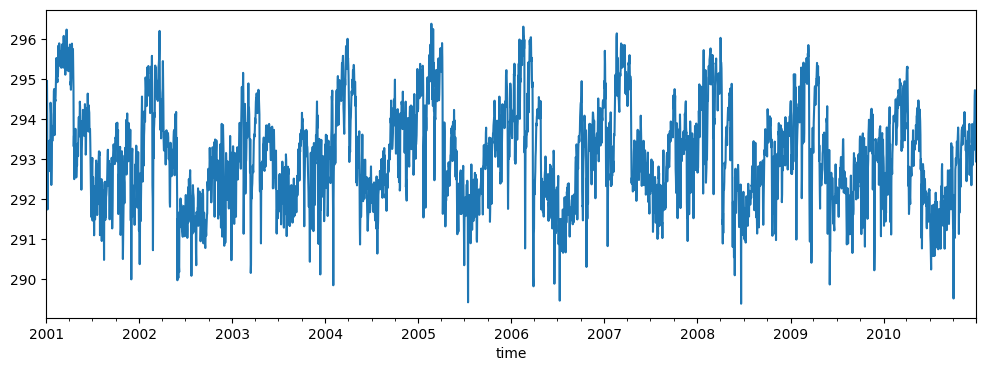

In [ ]:
# plot a time series of one of the regions as example
df.Bungoma.plot(figsize=(12, 4))
